# Model Metrics

In [51]:
import pandas as pd
import os
from glob import glob
from azureml.core import Workspace, Run
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy  as np
import json
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Load model run log

In [52]:
RUN_LOG = 'training_scripts/runids.csv'

In [53]:
df = pd.read_csv(RUN_LOG)
df.tail()

,runid,model_name,data_subset,start_time
32,birdsongs_2_1618597659_27bfc8cd,milsed_7block_dense,kaggle_full_length_npy_aug,"04/16/2021, 14:27:42"
33,birdsongs_2_1618597673_660ac2d5,milsed_7block_dense,kaggle_full_length_npy_aug_pitch,"04/16/2021, 14:27:56"
34,birdsongs_2_1618597685_86c04cfa,milsed_7block_dense,kaggle_full_length_npy_aug_stretch,"04/16/2021, 14:28:07"
35,birdsongs_2_1618597695_cf59e378,milsed_7block_dense,kaggle_full_length_npy_aug_pitch_stretch,"04/16/2021, 14:28:16"
36,birdsongs_2_1618704934_e5b73727,milsed_7block_dense,all_full_length_npy_aug,"04/17/2021, 20:15:40"


In [54]:
# drop test runs
df = df[df['runid'].str.split('_').str[0] != 'test']
df.head()

,runid,model_name,data_subset,start_time
0,birdsongs_2_1618101588_9cdc9314,cnn1_audin_nmel_1,kaggle_10sec_wav,"04/10/2021, 20:39:52"
1,birdsongs_2_1618101601_6c54df25,cnn1_audin_nmel_2,kaggle_10sec_wav,"04/10/2021, 20:40:03"
2,birdsongs_2_1618101679_621085b4,cnn1_audin_nmel_dcbl_1,kaggle_10sec_wav,"04/10/2021, 20:41:23"
3,birdsongs_2_1618101691_08bb6e9d,cnn1_audin_nmel_dcbl_2,kaggle_10sec_wav,"04/10/2021, 20:41:34"
4,birdsongs_2_1618105893_94d00361,cnn1_audin_nffthl_1,kaggle_10sec_wav,"04/10/2021, 21:51:37"


In [55]:
# get keep the last run of each model/data_subset pair
df_lastruns = df.drop_duplicates(subset=['model_name', 'data_subset'], 
                                 keep='last').copy()
df_lastruns.tail()

,runid,model_name,data_subset,start_time
32,birdsongs_2_1618597659_27bfc8cd,milsed_7block_dense,kaggle_full_length_npy_aug,"04/16/2021, 14:27:42"
33,birdsongs_2_1618597673_660ac2d5,milsed_7block_dense,kaggle_full_length_npy_aug_pitch,"04/16/2021, 14:27:56"
34,birdsongs_2_1618597685_86c04cfa,milsed_7block_dense,kaggle_full_length_npy_aug_stretch,"04/16/2021, 14:28:07"
35,birdsongs_2_1618597695_cf59e378,milsed_7block_dense,kaggle_full_length_npy_aug_pitch_stretch,"04/16/2021, 14:28:16"
36,birdsongs_2_1618704934_e5b73727,milsed_7block_dense,all_full_length_npy_aug,"04/17/2021, 20:15:40"


## Get from Azure

In [56]:
ws = Workspace.from_config()

In [57]:
# get run context from Azure for each runid
runs = {}
for runid in tqdm(df_lastruns['runid']):
    run = Run.get(ws, runid)
    runs[runid] = run

100%|██████████| 33/33 [00:12<00:00,  2.57it/s]


In [58]:
# eliminate failed runs
status = []
for runid, run in runs.items():
    status.append(run.status)
    
df_lastruns['status'] = status
df_lastruns.head()

,runid,model_name,data_subset,start_time,status
0,birdsongs_2_1618101588_9cdc9314,cnn1_audin_nmel_1,kaggle_10sec_wav,"04/10/2021, 20:39:52",Completed
1,birdsongs_2_1618101601_6c54df25,cnn1_audin_nmel_2,kaggle_10sec_wav,"04/10/2021, 20:40:03",Completed
2,birdsongs_2_1618101679_621085b4,cnn1_audin_nmel_dcbl_1,kaggle_10sec_wav,"04/10/2021, 20:41:23",Completed
3,birdsongs_2_1618101691_08bb6e9d,cnn1_audin_nmel_dcbl_2,kaggle_10sec_wav,"04/10/2021, 20:41:34",Completed
4,birdsongs_2_1618105893_94d00361,cnn1_audin_nffthl_1,kaggle_10sec_wav,"04/10/2021, 21:51:37",Completed


In [59]:
# keep only completed runs
df_complete = df_lastruns[df_lastruns['status'] == 'Completed']
df_complete = df_complete.set_index('runid')
df_complete.tail()

,model_name,data_subset,start_time,status
runid,,,,
birdsongs_2_1618597659_27bfc8cd,milsed_7block_dense,kaggle_full_length_npy_aug,"04/16/2021, 14:27:42",Completed
birdsongs_2_1618597673_660ac2d5,milsed_7block_dense,kaggle_full_length_npy_aug_pitch,"04/16/2021, 14:27:56",Completed
birdsongs_2_1618597685_86c04cfa,milsed_7block_dense,kaggle_full_length_npy_aug_stretch,"04/16/2021, 14:28:07",Completed
birdsongs_2_1618597695_cf59e378,milsed_7block_dense,kaggle_full_length_npy_aug_pitch_stretch,"04/16/2021, 14:28:16",Completed
birdsongs_2_1618704934_e5b73727,milsed_7block_dense,all_full_length_npy_aug,"04/17/2021, 20:15:40",Completed


### Download run files

In [60]:
# set path
OUT_DIR = 'model_data'
os.makedirs(OUT_DIR, exist_ok=True)

# get all files from DataFrame
for idx, row in df_complete.iterrows():
    
    # set filename
    file_path = os.path.join(OUT_DIR, f'{row.model_name}-{idx}*.h5')
    files = glob(file_path)
    
    # check if the files already exist
    if len(files):
        print(f'files for {idx} are already downloaded.')
    else:
        # download files
        print(f'downloading {idx} files')
        runs[idx].download_files(prefix='outputs', 
                                       output_directory=OUT_DIR, 
                                       append_prefix=False)

files for birdsongs_2_1618101588_9cdc9314 are already downloaded.
files for birdsongs_2_1618101601_6c54df25 are already downloaded.
files for birdsongs_2_1618101679_621085b4 are already downloaded.
files for birdsongs_2_1618101691_08bb6e9d are already downloaded.
files for birdsongs_2_1618105893_94d00361 are already downloaded.
files for birdsongs_2_1618105905_9510b3e7 are already downloaded.
files for birdsongs_2_1618109592_7b50fea5 are already downloaded.
files for birdsongs_2_1618109605_d3804748 are already downloaded.
files for birdsongs_2_1618147392_4d00cd64 are already downloaded.
files for birdsongs_2_1618147406_e8ed4602 are already downloaded.
files for birdsongs_2_1618150013_c2f1f4bf are already downloaded.
files for birdsongs_2_1618153363_7017415d are already downloaded.
files for birdsongs_2_1618153718_0f7f4e95 are already downloaded.
files for birdsongs_2_1618153737_76aab195 are already downloaded.
files for birdsongs_2_1618157490_39253a0e are already downloaded.
files for 

## Model History

### Training History

In [61]:
# get run metrics from saved file
run_metrics = []

# for each model
for idx, row in df_complete.iterrows():    
    
    # get file path
    file = os.path.join(OUT_DIR, f'{row.model_name}-{idx}' + '.history')
    
    with open(file, 'rb') as f:
        metric = pickle.load(f)
    metric['runid'] = idx
    metric['data_subset'] = row['data_subset']
    run_metrics.append(metric)
    
# convert to DataFrame
run_metrics = pd.DataFrame(run_metrics)
run_metrics.head(2)

,loss,categorical_accuracy,top_3_accuracy,top_5_accuracy,val_loss,val_categorical_accuracy,val_top_3_accuracy,val_top_5_accuracy,lr,runid,data_subset
0,"[5.553964614868164, 5.017866134643555, 4.44454...","[0.008900728076696396, 0.03586278483271599, 0....","[0.027676714584231377, 0.08666840195655823, 0....","[0.04320426285266876, 0.12649428844451904, 0.2...","[5.344659805297852, 4.781640529632568, 4.24124...","[0.018168604001402855, 0.05741279199719429, 0....","[0.039244186133146286, 0.13372093439102173, 0....","[0.0625, 0.19040697813034058, 0.31213662028312...","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...",birdsongs_2_1618101588_9cdc9314,kaggle_10sec_wav
1,"[5.668341159820557, 5.208738803863525, 4.79221...","[0.007276507094502449, 0.02507796324789524, 0....","[0.02176455222070217, 0.06477390974760056, 0.1...","[0.03436850383877754, 0.0953742191195488, 0.17...","[5.413963317871094, 5.012693405151367, 4.79702...","[0.014171511866152287, 0.032340116798877716, 0...","[0.03815406933426857, 0.08430232852697372, 0.1...","[0.053415697067976, 0.13299418985843658, 0.181...","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...",birdsongs_2_1618101601_6c54df25,kaggle_10sec_wav


### Test metrics

In [62]:
# get test metrics from saved test metrics
test_metrics = []

# for each model
for idx, row in df_complete.iterrows():    
    
    # get filename
    file = os.path.join(OUT_DIR, f'{row.model_name}-{idx}-test_metrics.pkl')
    
    # load saved metrics
    with open(file, 'rb') as f:
        metric = pickle.load(f)
    metric['runid'] = idx
    metric['model_name'] = row.model_name
    test_metrics.append(metric)
    
# convert to dataframe
test_metrics = pd.DataFrame(test_metrics)
test_metrics.head(3)

,test_categorical_accuracy,test_top_3_accuracy,test_top_5_accuracy,runid,model_name
0,0.324375,0.493437,0.572500,birdsongs_2_1618101588_9cdc9314,cnn1_audin_nmel_1
1,0.283125,0.454062,0.540625,birdsongs_2_1618101601_6c54df25,cnn1_audin_nmel_2
2,0.304688,0.480000,0.573750,birdsongs_2_1618101679_621085b4,cnn1_audin_nmel_dcbl_1


### Join into a single DataFrame
This DataFrame will be used here for visualizations and in the project dashboard.

In [63]:
# Join on runid
df_metrics = run_metrics.set_index('runid').join(test_metrics.set_index('runid'))
df_metrics.head(2)

,loss,categorical_accuracy,top_3_accuracy,top_5_accuracy,val_loss,val_categorical_accuracy,val_top_3_accuracy,val_top_5_accuracy,lr,data_subset,test_categorical_accuracy,test_top_3_accuracy,test_top_5_accuracy,model_name
runid,,,,,,,,,,,,,,
birdsongs_2_1618101588_9cdc9314,"[5.553964614868164, 5.017866134643555, 4.44454...","[0.008900728076696396, 0.03586278483271599, 0....","[0.027676714584231377, 0.08666840195655823, 0....","[0.04320426285266876, 0.12649428844451904, 0.2...","[5.344659805297852, 4.781640529632568, 4.24124...","[0.018168604001402855, 0.05741279199719429, 0....","[0.039244186133146286, 0.13372093439102173, 0....","[0.0625, 0.19040697813034058, 0.31213662028312...","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...",kaggle_10sec_wav,0.324375,0.493437,0.572500,cnn1_audin_nmel_1
birdsongs_2_1618101601_6c54df25,"[5.668341159820557, 5.208738803863525, 4.79221...","[0.007276507094502449, 0.02507796324789524, 0....","[0.02176455222070217, 0.06477390974760056, 0.1...","[0.03436850383877754, 0.0953742191195488, 0.17...","[5.413963317871094, 5.012693405151367, 4.79702...","[0.014171511866152287, 0.032340116798877716, 0...","[0.03815406933426857, 0.08430232852697372, 0.1...","[0.053415697067976, 0.13299418985843658, 0.181...","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...",kaggle_10sec_wav,0.283125,0.454062,0.540625,cnn1_audin_nmel_2


In [64]:
# save this file for use in the dashboard
df_metrics.to_pickle('df_metrics.pkl')

## Plot model test performance

In [65]:
# create new DF
df_plot = df_metrics.copy()

# Create new model_name on two lines
df_plot['model'] = df_plot['model_name'] + '<br>' + df_plot['data_subset']

# Add a model number
df_plot['model_num'] = range(1, len(df_plot) + 1)

# Create a text representation of model #
df_plot['model_num_text'] = 'Model #' + df_plot['model_num'].astype('str')

df_plot.head(3)

,loss,categorical_accuracy,top_3_accuracy,top_5_accuracy,val_loss,val_categorical_accuracy,val_top_3_accuracy,val_top_5_accuracy,lr,data_subset,test_categorical_accuracy,test_top_3_accuracy,test_top_5_accuracy,model_name,model,model_num,model_num_text
runid,,,,,,,,,,,,,,,,,
birdsongs_2_1618101588_9cdc9314,"[5.553964614868164, 5.017866134643555, 4.44454...","[0.008900728076696396, 0.03586278483271599, 0....","[0.027676714584231377, 0.08666840195655823, 0....","[0.04320426285266876, 0.12649428844451904, 0.2...","[5.344659805297852, 4.781640529632568, 4.24124...","[0.018168604001402855, 0.05741279199719429, 0....","[0.039244186133146286, 0.13372093439102173, 0....","[0.0625, 0.19040697813034058, 0.31213662028312...","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...",kaggle_10sec_wav,0.324375,0.493437,0.572500,cnn1_audin_nmel_1,cnn1_audin_nmel_1<br>kaggle_10sec_wav,1,Model #1
birdsongs_2_1618101601_6c54df25,"[5.668341159820557, 5.208738803863525, 4.79221...","[0.007276507094502449, 0.02507796324789524, 0....","[0.02176455222070217, 0.06477390974760056, 0.1...","[0.03436850383877754, 0.0953742191195488, 0.17...","[5.413963317871094, 5.012693405151367, 4.79702...","[0.014171511866152287, 0.032340116798877716, 0...","[0.03815406933426857, 0.08430232852697372, 0.1...","[0.053415697067976, 0.13299418985843658, 0.181...","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...",kaggle_10sec_wav,0.283125,0.454062,0.540625,cnn1_audin_nmel_2,cnn1_audin_nmel_2<br>kaggle_10sec_wav,2,Model #2
birdsongs_2_1618101679_621085b4,"[5.546006202697754, 5.219290256500244, 4.70500...","[0.00513253640383482, 0.01396829541772604, 0.0...","[0.015007796697318554, 0.038916319608688354, 0...","[0.0257276501506567, 0.0641242191195488, 0.169...","[5.376589775085449, 4.9785356521606445, 4.3890...","[0.014171511866152287, 0.024709302932024002, 0...","[0.030159883201122284, 0.06758721172809601, 0....","[0.04832848906517029, 0.10901162773370743, 0.2...","[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...",kaggle_10sec_wav,0.304688,0.480000,0.573750,cnn1_audin_nmel_dcbl_1,cnn1_audin_nmel_dcbl_1<br>kaggle_10sec_wav,3,Model #3


In [66]:
# create DataFrame with only columns we need for plot
df_plot = df_plot[['model_name',
                   'data_subset',
                   'model_num_text',
                   'test_categorical_accuracy', 
                   'test_top_3_accuracy', 
                   'test_top_5_accuracy']]
df_plot.head(3)

,model_name,data_subset,model_num_text,test_categorical_accuracy,test_top_3_accuracy,test_top_5_accuracy
runid,,,,,,
birdsongs_2_1618101588_9cdc9314,cnn1_audin_nmel_1,kaggle_10sec_wav,Model #1,0.324375,0.493437,0.572500
birdsongs_2_1618101601_6c54df25,cnn1_audin_nmel_2,kaggle_10sec_wav,Model #2,0.283125,0.454062,0.540625
birdsongs_2_1618101679_621085b4,cnn1_audin_nmel_dcbl_1,kaggle_10sec_wav,Model #3,0.304688,0.480000,0.573750


In [67]:
# rename columns for plot
df_plot.columns = ['Model Name',
                   'Data',
                   'Model No.',
                   'Categorical Accuracy',
                   'Top 3 Categorical Accuracy',
                   'Top 5 Categorical Accuracy']

# flatten dataframe for plot
df_plot = df_plot.melt(id_vars=['Model Name', 'Data', 'Model No.'],
                       var_name='Accuracy Metric',
                       value_vars=['Categorical Accuracy', 
                                      'Top 3 Categorical Accuracy', 
                                      'Top 5 Categorical Accuracy'],
                       value_name='Accuracy')
df_plot.head()

,Model Name,Data,Model No.,Accuracy Metric,Accuracy
0,cnn1_audin_nmel_1,kaggle_10sec_wav,Model #1,Categorical Accuracy,0.324375
1,cnn1_audin_nmel_2,kaggle_10sec_wav,Model #2,Categorical Accuracy,0.283125
2,cnn1_audin_nmel_dcbl_1,kaggle_10sec_wav,Model #3,Categorical Accuracy,0.304688
3,cnn1_audin_nmel_dcbl_2,kaggle_10sec_wav,Model #4,Categorical Accuracy,0.268750
4,cnn1_audin_nffthl_1,kaggle_10sec_wav,Model #5,Categorical Accuracy,0.302500


In [68]:
# the color palette
colors = ['#6c503e', '#446652','#8C93A8', '#EDCB96', '#B5C2B7']


In [70]:
# accuracy plot with plotly for dashboard
fig = px.bar(df_plot.sort_values('Accuracy'), x='Model No.', 
             y='Accuracy', color='Accuracy Metric', 
             barmode='group',
             hover_name='Model No.',
             hover_data=['Model Name', 'Data'],
             color_discrete_sequence=colors,
             title='Test Accuracy by model name')

# formatting
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    annotations = [
        dict(xref='paper',
             yref='paper',
             x=0, y=1.13,
             showarrow=False,
             text ='Hover to see Model Name and Dataset'
        )
    ],
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor='rgba(0,0,0,0)',
    font = {'color':'black'}
)


## Rebuild best model

In [20]:
# Import model generator function
from training_scripts.remote.models import MODELS

In [21]:
# Get best model
best_model = df_metrics.sort_values('test_categorical_accuracy').iloc[-1]
best_model

loss                         [4.934966564178467, 3.955747604370117, 3.49586...
categorical_accuracy         [0.0772431269288063, 0.1730734407901764, 0.241...
top_3_accuracy               [0.14736342430114746, 0.29741770029067993, 0.3...
top_5_accuracy               [0.1950298547744751, 0.37384676933288574, 0.48...
val_loss                     [4.559544086456299, 3.6354827880859375, 3.3458...
val_categorical_accuracy     [0.12282274663448334, 0.22259221971035004, 0.2...
val_top_3_accuracy           [0.21170593798160553, 0.36565062403678894, 0.4...
val_top_5_accuracy           [0.27126023173332214, 0.4514600336551666, 0.51...
lr                           [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...
data_subset                                            all_full_length_npy_aug
test_categorical_accuracy                                             0.704704
test_top_3_accuracy                                                   0.816747
test_top_5_accuracy                                 

In [22]:
# model weights filename
fname = f'model_data/{best_model.model_name}-{best_model.name}.h5'

# create model
model = MODELS[df_metrics.loc[idx].model_name]()

# load model weights
model.load_weights(fname)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stft (STFT)                  (None, 427, 1025, 1)      0         
_________________________________________________________________
magnitude (Magnitude)        (None, 427, 1025, 1)      0         
_________________________________________________________________
apply_filterbank (ApplyFilte (None, 427, 256, 1)       0         
_________________________________________________________________
magnitude_to_decibel (Magnit (None, 427, 256, 1)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 427, 256, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 427, 256, 16)      160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 427, 256, 16)      6

In [24]:
# number of layers in the model
len(model.layers)

44

# Metric Plots
## Plot test accuracy

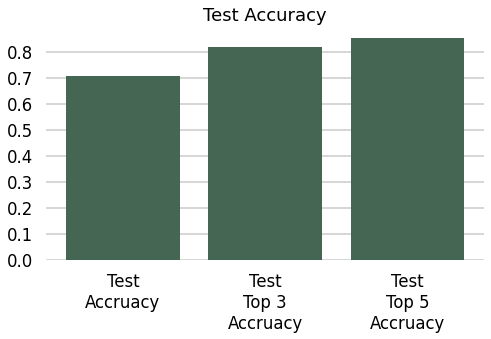

In [25]:
# create new dataframe for plotting
df_plot = pd.DataFrame(best_model[['test_categorical_accuracy', 
                                  'test_top_3_accuracy', 
                                  'test_top_5_accuracy']])

#plot
with plt.style.context('fivethirtyeight'), sns.plotting_context("talk", font_scale=1):
        
    fig = plt.figure(figsize=(7,4))
    plt.bar(x=df_plot.index, 
            height = df_plot[best_model.name],
            color=colors[1])
    
    # Labels
    plt.xticks([0,1,2], ['Test\nAccruacy', 
                         'Test\nTop 3\nAccruacy', 
                         'Test\nTop 5\nAccruacy'])
    plt.title('Test Accuracy')
    
    # formatting
    plt.grid(axis='x')
    plt.box(False)
    ax = plt.gca()
    ax.tick_params(axis='both', left=False, bottom=False)

    # Make Transparent (for presentation)
    fig.set_facecolor('None')
    ax.set_facecolor('None')

## Best Model Accuracy and Val Accuracy

In [26]:
# Create Accuracy DataFrame for Plotting with plotly
df_acc = pd.DataFrame(best_model['categorical_accuracy'], 
                      columns=['categorical_accuracy'])
df_acc.index = pd.Series(range(1, len(df_acc) + 1), name='Epochs')
df_acc['model'] = best_model['model_name'] + '/' + best_model['data_subset']

val_accuracy = pd.DataFrame(best_model['val_categorical_accuracy'], 
                            columns=['val_categorical_accuracy'])
top_3_accuracy = pd.DataFrame(best_model['top_3_accuracy'], 
                              columns=['top_3_accuracy'])
val_top_3_accuracy = pd.DataFrame(best_model['val_top_3_accuracy'], 
                                  columns=['val_top_3_accuracy'])
top_5_accuracy = pd.DataFrame(best_model['top_5_accuracy'], 
                              columns=['top_5_accuracy'])
val_top_5_accuracy = pd.DataFrame(best_model['val_top_5_accuracy'], 
                                  columns=['val_top_5_accuracy'])

# combine dataframes into one for plotting
df_plt = pd.concat([df_acc,
                    val_accuracy,
                    top_3_accuracy,
                    val_top_3_accuracy,
                    top_5_accuracy,
                    val_top_5_accuracy], axis=1)

df_plt['Epochs'] = range(1, len(df_plt)+1)
df_plt['model_name'] = best_model['model_name'] + '<br>' + best_model['data_subset']

df_plt.head()

,categorical_accuracy,model,val_categorical_accuracy,top_3_accuracy,val_top_3_accuracy,top_5_accuracy,val_top_5_accuracy,Epochs,model_name
0,NaN,NaN,0.122823,0.147363,0.211706,0.195030,0.271260,1,milsed_7block_dense<br>all_full_length_npy_aug
1,0.077243,milsed_7block_dense/all_full_length_npy_aug,0.222592,0.297418,0.365651,0.373847,0.451460,2,milsed_7block_dense<br>all_full_length_npy_aug
2,0.173073,milsed_7block_dense/all_full_length_npy_aug,0.262679,0.397431,0.423924,0.482340,0.510886,3,milsed_7block_dense<br>all_full_length_npy_aug
3,0.241792,milsed_7block_dense/all_full_length_npy_aug,0.325179,0.466624,0.499744,0.547146,0.586834,4,milsed_7block_dense<br>all_full_length_npy_aug
4,0.295903,milsed_7block_dense/all_full_length_npy_aug,0.369109,0.513454,0.551998,0.595604,0.637935,5,milsed_7block_dense<br>all_full_length_npy_aug


In [50]:
fig = go.Figure()

# Add trace for Accuracy and Validation
fig.add_trace(go.Scatter(y=df_plt['categorical_accuracy'], 
                         x=df_plt['Epochs'],
                         name='<b>Accuracy:</b><br>' + df_plt['model_name'].iloc[0],
                         line = dict(color=colors[0], dash='solid')))
fig.add_trace(go.Scatter(y=df_plt['val_categorical_accuracy'], 
                         x=df_plt['Epochs'],
                         name='<b>Val. Accccuracy:</b><br>' + df_plt['model_name'].iloc[0],
                         line = dict(color=colors[0], dash='dash')))

fig.update_layout(go.Layout(title="Accuracy vs Validation Accuracy"))

# formatting
fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=0.02,
        xanchor="right",
        x=0.99
    )
)

### Accuracy Subplots

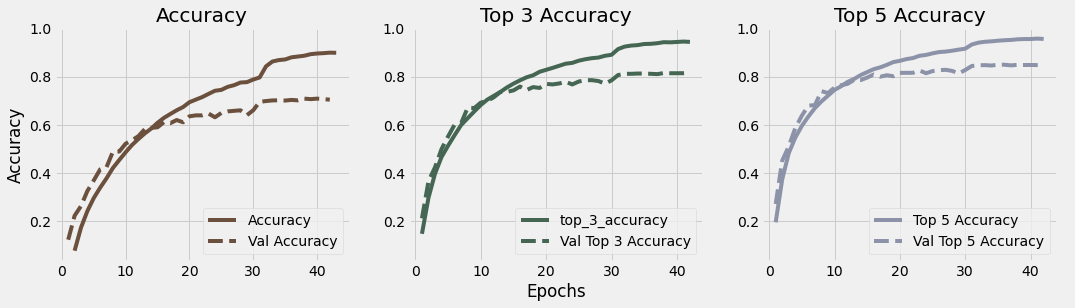

In [28]:
with plt.style.context('fivethirtyeight'):

    fig, axs = plt.subplots(1, 3, sharey=True, figsize = (16,4))

    # Cagegorical Accuracy
    axs[0].plot(df_plt['Epochs'],
             df_plt['categorical_accuracy'],
             color=colors[0],
             label="Accuracy")
    axs[0].plot(df_plt['Epochs'],
             df_plt['val_categorical_accuracy'],
             linestyle='--',
             color=colors[0],
             label='Val Accuracy')
    axs[0].legend(loc='lower right')
    axs[0].set_title('Accuracy')

    # Top 3 Accuracy
    axs[1].plot(df_plt['Epochs'],
             df_plt['top_3_accuracy'],
             color=colors[1],
             label='top_3_accuracy')
    axs[1].plot(df_plt['Epochs'],
             df_plt['val_top_3_accuracy'],
             linestyle='--',
             color=colors[1],
             label='Val Top 3 Accuracy')
    axs[1].set_title('Top 3 Accuracy')


    axs[1].set_xticks([0,10,20,30,40])
    axs[1].set_yticks(axs[0].get_yticks())
    axs[1].tick_params(labelleft=True)
    axs[1].legend()

    # Top 5 Accuracy
    axs[2].plot(df_plt['Epochs'],
             df_plt['top_5_accuracy'],
             color=colors[2],
             label='Top 5 Accuracy')
    axs[2].plot(df_plt['Epochs'],
             df_plt['val_top_5_accuracy'],
             linestyle='--',
             color=colors[2],
             label='Val Top 5 Accuracy')
    axs[2].set_xticks([0,10,20,30,40])
    axs[2].tick_params(labelleft=True)
    axs[2].set_title('Top 5 Accuracy')
    axs[2].legend()
    
    # Superimpose plot for shared x axis
    fig.add_subplot(111, frameon=False)
    
    # hide tick and tick label of the big axis
    plt.grid(False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    
    # Shared labels
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    

## Confusion Matrix

In [29]:
# Load keys with ground truth
with open('data/resources/data_kag_split_single_label.json', 'r') as fp:
    split = json.load(fp)
    
split.keys()

dict_keys(['mapping', 'train', 'val', 'test'])

In [30]:
# map for label names
label_map = split['mapping']

In [31]:
# Ground Truth
y_true = split['test']['encoded_labels']
y_true[:5]

[0, 0, 0, 0, 0]

In [32]:
# Ground truth names
y_true_names = split['test']['labels']
y_true_names[:5]

['Alder Flycatcher',
 'Alder Flycatcher',
 'Alder Flycatcher',
 'Alder Flycatcher',
 'Alder Flycatcher']

In [33]:
# open saved predictions
fname = f'{best_model.model_name}-{best_model.name}-test_predictions.pkl'
fname = os.path.join('model_data', fname)
with open(fname, 'rb') as fp:
    y_pred = pickle.load(fp)    

In [34]:
# Convert predictions to names
y_pred_names = [label_map[i] for i in np.argmax(y_pred, axis=1)]
y_pred_names[:5]

['American Robin',
 'Alder Flycatcher',
 'Alder Flycatcher',
 'Sharp-shinned Hawk',
 'Alder Flycatcher']

In [35]:
# double check accuracy
accuracy_score(y_true_names, y_pred_names)

0.8280274656679151

I believe this is higher than tensorflow because sklearn is averaging the accuracy by class rather than reporting overall accuracy.

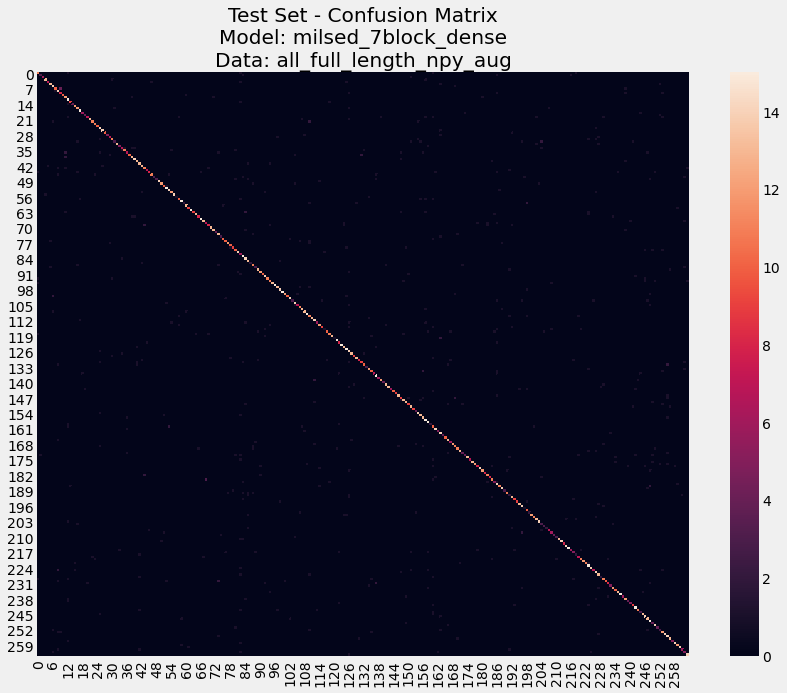

In [36]:
# confusiion matrix
cf_matrix = confusion_matrix(y_true_names, y_pred_names)

# plot it
with plt.style.context('fivethirtyeight'): #, sns.plotting_context("talk", font_scale=1.4):

    fig = plt.figure(figsize=(13,10))
    sns.heatmap(cf_matrix)
    
    # Title
    plt.title(f'''Test Set - Confusion Matrix
Model: {best_model.model_name}
Data: {best_model.data_subset}''');

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_true_names, y_pred_names))

                               precision    recall  f1-score   support

             Alder Flycatcher       0.69      0.73      0.71        15
              American Avocet       0.75      0.50      0.60         6
             American Bittern       1.00      0.86      0.92         7
             American Bushtit       0.93      0.87      0.90        15
       American Cliff Swallow       0.88      0.70      0.78        10
                American Coot       0.87      0.87      0.87        15
                American Crow       0.70      0.93      0.80        15
    American Dusky Flycatcher       0.91      0.67      0.77        15
           American Goldfinch       0.61      0.93      0.74        15
     American Grey Flycatcher       0.62      0.67      0.64        12
             American Kestrel       1.00      0.91      0.95        11
            American Redstart       0.67      0.80      0.73        15
               American Robin       0.60      1.00      0.75        15
     

# CPU/GPU Utilization

In [38]:
# read log
df_p = pd.read_csv(f'model_data/{best_model.name}-log_compute.csv', index_col=0)

# convert index to datetime
df_p.index = pd.to_datetime(df_p.index, unit='s', origin='unix') 

df_p

,CPU (%),RAM (%),Swap (%),0:GPU (%),0:Mem (%),0:Temp (C)
Timestamp (s),,,,,,
2021-04-18 00:22:27.917999872,16.4,10.0,0.0,0,0,38
2021-04-18 00:22:28.117000192,14.5,10.1,0.0,1,0,39
2021-04-18 00:22:28.316000000,4.2,10.1,0.0,0,0,39
2021-04-18 00:22:28.516000000,13.1,10.3,0.0,2,0,39
2021-04-18 00:22:28.714999808,16.9,10.5,0.0,4,0,39
...,...,...,...,...,...,...
2021-04-22 18:09:23.730000128,24.1,16.4,0.0,0,0,66
2021-04-22 18:09:24.708000000,14.0,16.5,0.0,0,0,66
2021-04-22 18:09:25.658999808,23.1,16.5,0.0,0,0,66


In [39]:
df_p.describe()

,CPU (%),RAM (%),Swap (%),0:GPU (%),0:Mem (%),0:Temp (C)
count,748398.000000,748398.000000,748398.0,748398.000000,748398.000000,748398.000000
mean,31.258256,26.790940,0.0,6.923856,4.076283,60.443955
std,7.879350,5.625783,0.0,23.252510,14.122435,0.885262
min,0.000000,10.000000,0.0,0.000000,0.000000,38.000000
25%,25.500000,22.100000,0.0,0.000000,0.000000,60.000000
50%,29.700000,25.700000,0.0,0.000000,0.000000,60.000000
75%,35.600000,31.100000,0.0,0.000000,0.000000,61.000000
max,100.000000,62.300000,0.0,100.000000,74.000000,71.000000


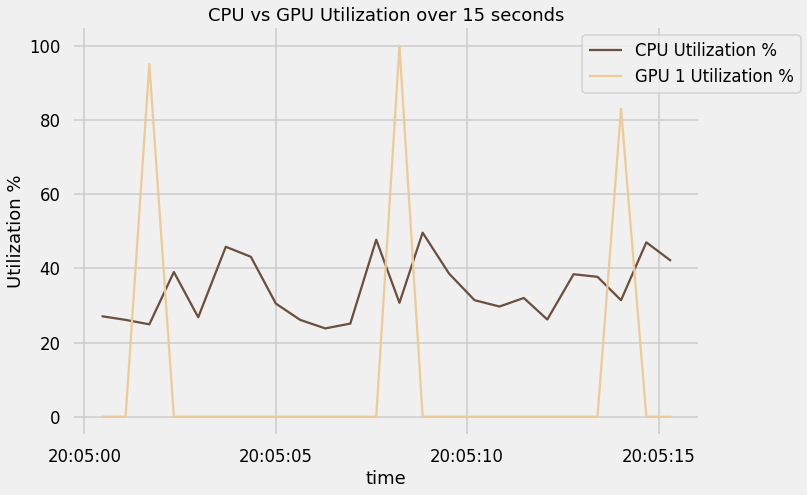

In [40]:
# plot cpu gpu utilization
with plt.style.context('fivethirtyeight'), sns.plotting_context("talk", font_scale=1):

    fig = plt.figure(figsize=(10,7))
    df_slice = df_p.loc['2021-04-20 20:05':'2021-04-20 20:05:15']
    plt.plot(df_slice['CPU (%)'], label='CPU Utilization %', color=colors[0])
    plt.plot(df_slice['0:GPU (%)'], label='GPU 1 Utilization %', color=colors[3])
    
    # labels
    plt.title('CPU vs GPU Utilization over 15 seconds')
    plt.ylabel('Utilization %')
    plt.xlabel('time')
    
    # formatting
    plt.legend(bbox_to_anchor=(0.8, 1), loc='upper left')
    plt.tick_params(which='both', top=False, bottom=False, left=False, right=False)

The training did not make full use of compute resources on the system.  In particular the GPUs were vastly underutilized.  This appears to be the result of file load times because the CPUS (which were used in parallel to process the audio) rarely passed 100%.  MEan GPU utilization of arround 28% is very low.

# Future Work

1. Further improvements might be possible by **testing other model architectures** like LSTM or attention based networks.
2. Create a Sound Event Detection model leveraging the AutoPooling layer from “Adaptive Pooling Operators for Weakly Labeled Sound Event Detection.”  This could have the added benefit of detecting multiple species in a recording.
3. Develop an open source mobile app so the community can improve the modeling and the benefits of the model can be leveraged by hobbyists and researchers alike.
4. Improve training efficiency by using a different data loading methodology.

# Conclusion

Its clear form this work that bird vocalization classification is a viable way to classify bird species.  Pitch shift and time stretching the audio data had a nominally negative effect on the model performance, and are computationally expensive, therefor use of those augmentation strategies is not recommended.  Data augmentation by selecting random samples and downloading more samples does significantly improve the training.